In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pylab import rcParams
from platform import python_version

print(python_version())
print(tf.__version__)

3.7.12
2.7.0


In [71]:
rcParams['figure.figsize'] = (10, 6)

In [72]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df_raw = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [73]:
labels = df_raw[:, -1]
data = df_raw[:, :-1]

print(labels.shape)
print(data.shape)

(4998,)
(4998, 140)


In [74]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=10)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3998, 140)
(3998,)
(1000, 140)
(1000,)


In [75]:
scaler = MinMaxScaler()
scaler.fit(x_train)
scaler.fit(x_test)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [76]:
x_train[0][:10]

array([0.8026665 , 0.7483631 , 0.52808921, 0.38542811, 0.18129497,
       0.11578003, 0.16163981, 0.31565831, 0.27183197, 0.3708654 ])

In [77]:
x_test[0][:10]

array([0.39731649, 0.196874  , 0.07684229, 0.12931236, 0.23049202,
       0.3802482 , 0.40782177, 0.38753806, 0.47966165, 0.51812989])

In [78]:
x_train = tf.cast(x_train, tf.float64)
x_test = tf.cast(x_test, tf.float64)

In [79]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)
print(y_train[:10])
print(y_test[:10])

[ True False  True  True  True  True False  True  True  True]
[ True False  True  True  True  True  True False  True False]


In [80]:
x_train_norm = x_train[y_train]
x_test_norm = x_test[y_test]

x_train_anom = x_train[~y_train]
x_test_anom = x_test[~y_test]

In [81]:
print(x_train_norm.shape)
print(x_train_anom.shape)

(2346, 140)
(1652, 140)


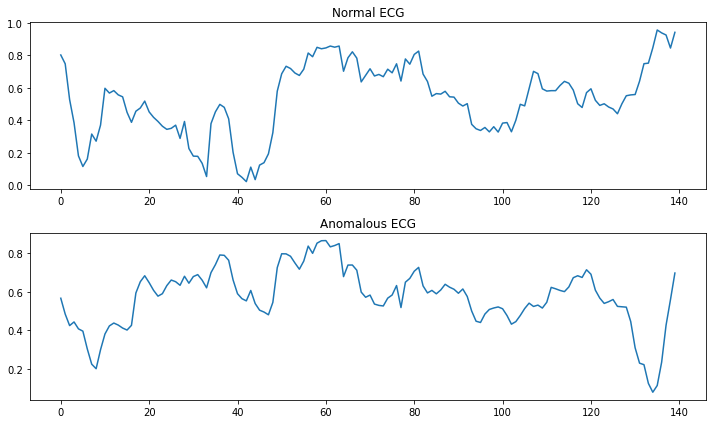

In [82]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(np.arange(x_train_norm.shape[1]), x_train_norm[0])
ax1.set_title('Normal ECG')
ax2.plot(np.arange(x_train_anom.shape[1]), x_train_anom[0])
ax2.set_title('Anomalous ECG')
plt.tight_layout()
plt.show()

In [83]:
data_input = layers.Input(shape=[None, 140])
x = layers.Dense(64, activation='relu')(data_input)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
encoder = layers.Dense(8, activation='relu')(x)

x = layers.Dense(16, activation='relu')(encoder)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
decoder = layers.Dense(140, activation='sigmoid')(x)

autoencoder = keras.Model(data_input, decoder)
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 140)]       0         
                                                                 
 dense_24 (Dense)            (None, None, 64)          9024      
                                                                 
 dense_25 (Dense)            (None, None, 32)          2080      
                                                                 
 dense_26 (Dense)            (None, None, 16)          528       
                                                                 
 dense_27 (Dense)            (None, None, 8)           136       
                                                                 
 dense_28 (Dense)            (None, None, 16)          144       
                                                                 
 dense_29 (Dense)            (None, None, 32)          544 

In [84]:
epochs = 100
batch_size = 64

autoencoder.compile(optimizer=Adam(lr=1e-3), loss='mae')

history = autoencoder.fit(x_train_norm, 
                          x_train_norm, 
                          epochs=epochs, 
                          batch_size=batch_size,
                          validation_data=(x_test, x_test),
                          shuffle=True)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/37 [==============================] - 1s 9ms/step - loss: 0.1295 - val_loss: 0.1120
Epoch 2/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0680 - val_loss: 0.0979
Epoch 3/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0607 - val_loss: 0.0909
Epoch 4/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0535 - val_loss: 0.0829
Epoch 5/100
37/37 [==============================] - 0s 5ms/step - loss: 0.0494 - val_loss: 0.0818
Epoch 6/100
37/37 [==============================] - 0s 5ms/step - loss: 0.0471 - val_loss: 0.0794
Epoch 7/100
37/37 [==============================] - 0s 5ms/step - loss: 0.0433 - val_loss: 0.0766
Epoch 8/100
37/37 [==============================] - 0s 5ms/step - loss: 0.0403 - val_loss: 0.0751
Epoch 9/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0391 - val_loss: 0.0745
Epoch 10/100
37/37 [==============================] - 0s 5ms/step - loss: 0.0386 - val_loss: 0.0740
Epoch 11/100
37/37 [=

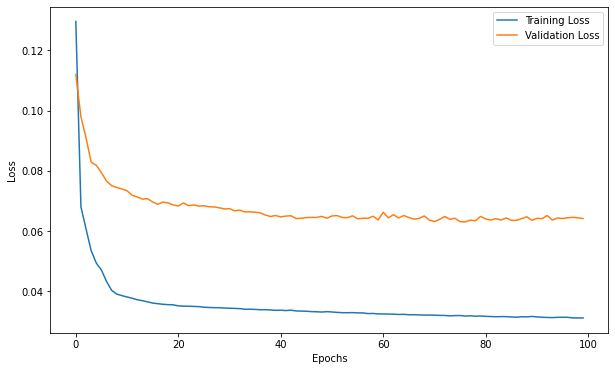

In [85]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [86]:
encoder = keras.Model(data_input, encoder)
encoded_data = encoder.predict(x_train_norm)

decoder = keras.Model(data_input, decoder)
decoded_data = decoder.predict(x_train_norm)

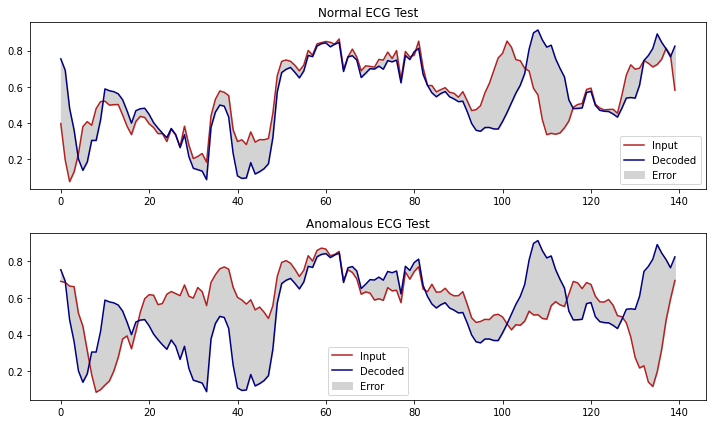

In [87]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(x_test_norm[0], c='firebrick', label='Input')
ax1.plot(decoded_data[0], c='navy', label='Decoded')
ax1.fill_between(np.arange(140), 
                 decoded_data[0], 
                 x_test_norm[0], 
                 color='lightgray',
                 label='Error')
ax1.set_title('Normal ECG Test')
ax1.legend()

ax2.plot(x_test_anom[0], c='firebrick', label='Input')
ax2.plot(decoded_data[0], c='navy', label='Decoded')
ax2.fill_between(np.arange(140), 
                 decoded_data[0], 
                 x_test_anom[0], 
                 color='lightgray',
                 label='Error')
ax2.set_title('Anomalous ECG Test')
ax2.legend()
plt.tight_layout()
plt.show()

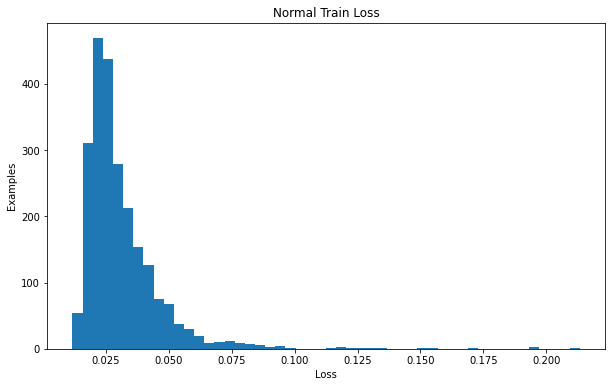

In [88]:
decoded_data_norm = decoder.predict(x_train_norm)
train_loss_norm = tf.keras.losses.mae(decoded_data_norm, x_train_norm)

plt.hist(train_loss_norm, bins=50)
plt.title('Normal Train Loss')
plt.xlabel('Loss')
plt.ylabel('Examples')
plt.show()

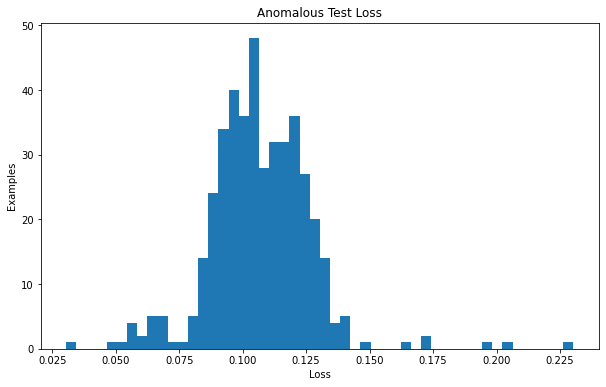

In [89]:
decoded_data_anom = decoder.predict(x_test_anom)
test_loss_anom = tf.keras.losses.mae(decoded_data_anom, x_test_anom)

plt.hist(test_loss_anom, bins=50)
plt.title('Anomalous Test Loss')
plt.xlabel('Loss')
plt.ylabel('Examples')
plt.show()

In [90]:
threshold = np.mean(train_loss_norm) + np.std(train_loss_norm)
print(f'Threshold: {threshold}')

Threshold: 0.04681539130377009


In [91]:
def anomaly_detection(data, threshold):
  decoded_data = decoder.predict(data)
  loss = tf.keras.losses.mae(decoded_data, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  accuracy = accuracy_score(labels, predictions)
  precision = precision_score(labels, predictions)
  recall = recall_score(labels, predictions)
  print(f'Accuracy = {round(accuracy, 4)}')
  print(f'Precision = {round(precision, 4)}')
  print(f'Recall = {round(recall, 4)}')

In [92]:
predictions = anomaly_detection(x_test, threshold)
print_stats(predictions, y_test)

Accuracy = 0.924
Precision = 0.998
Recall = 0.8691
